In [ ]:
!nvidia-smi #runs significantly faster on GPU

Mon May 20 08:46:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
HOME = os.getcwd()
print(HOME)


In [ ]:
#import vidoe for example
%cd {HOME}
SOURCE_VIDEO_PATH = f"{HOME}/m6traffic.mp4"

/content


In [ ]:
!pip install ultralytics==8.0.10
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks();

Ultralytics YOLOv8.0.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.9/78.2 GB disk)


In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack


!sed -i 's/onnc==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

!pip install -q loguru lap thop

from IPython import display
display.clear_output()

import sys
sys.path.append(f"{HOME}/ByteTrack")



In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


In [ ]:
!pip install supervision==0.1.0

In [ ]:
import supervision
print("yolox.__version__:",supervision.__version__);

yolox.__version__: 0.1.0


In [ ]:
from ultralytics import YOLO

MODEL = "yolov8x.pt"

model = YOLO(MODEL);
model.fuse();

100%|██████████| 131M/131M [00:00<00:00, 174MB/s]

Fusing... 
YOLOv8x summary: 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [ ]:
%cd /content

/content


In [ ]:
!yolo task=detect mode=predict model=yolov8x.pt conf=0.25 source={SOURCE_VIDEO_PATH};

2024-05-20 09:11:32.987425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 09:11:32.987485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 09:11:33.097533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 09:11:34.209369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
100% 131M/131M [00:00<00:00, 300MB/s]

Fusing... 
YOLOv8x summary: 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs
Traceback (most recent call 

In [ ]:
from supervision.video.source import get_video_frames_generator
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.draw.color import ColorPalette

In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT; #can see the class_ids of interest

###################################################
CLASS_ID = [2,3,5,7]

Ultralytics YOLOv8.0.10 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


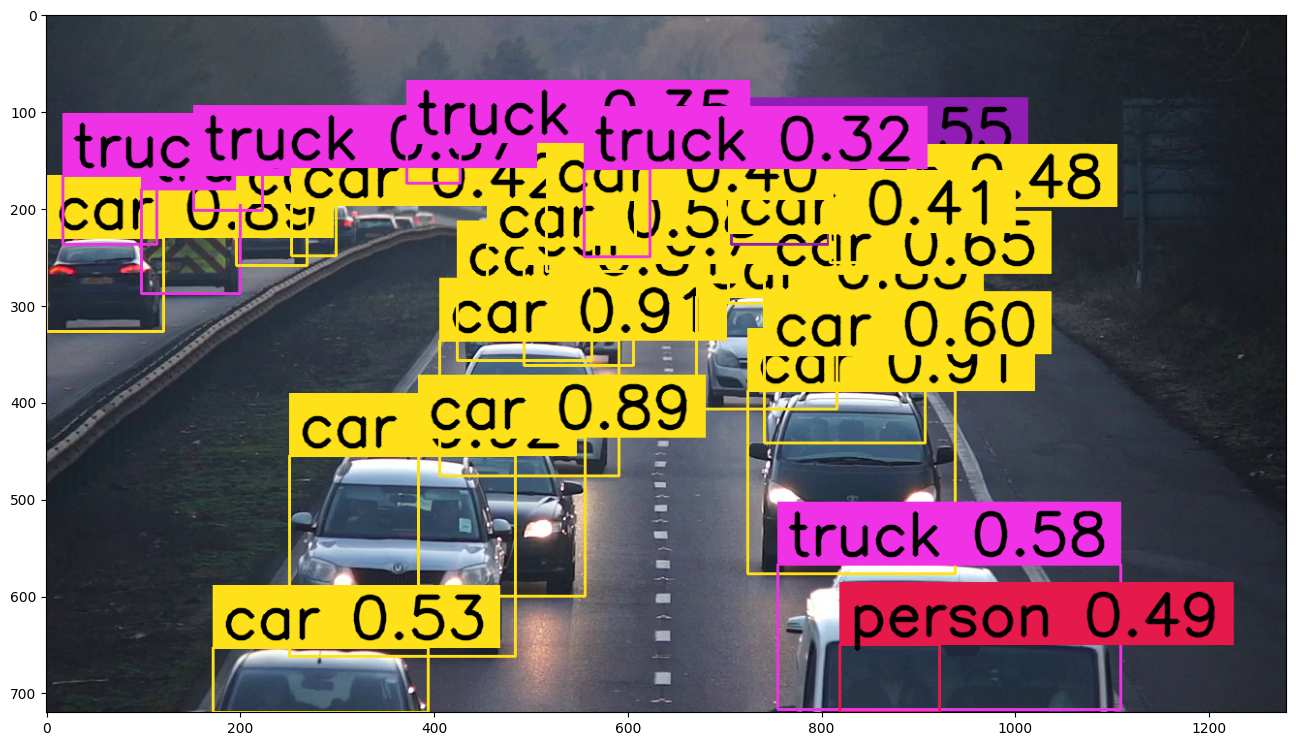

In [ ]:
generator = get_video_frames_generator(SOURCE_VIDEO_PATH);

#instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(),
                             thickness=2,text_thickness=4,
                             text_scale=2
)

#first video frame
iterator = iter(generator)
frame = next(iterator)

#model predictions on frames to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

#formatting my labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

#annotate and display the frames

frame = box_annotator.annotate(frame=frame, detections=detections,
                               labels=labels)

%matplotlib inline
show_frame_in_notebook(frame,(16,16));

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
  track_thresh: float=0.25
  track_buffer: int=30
  match_thresh: float=0.8
  aspect_ratio_threshold: float =3.0
  min_box_area: float =1.0
  mot20: bool = False

In [ ]:
%pwd

'/content'

In [ ]:
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from supervision.video.sink import VideoSink
import numpy as np

In [ ]:
LINE_START = Point(50,10) #x and y for the line, when an object skips, do the counting

LINE_END = Point(1280-50, 10);

TARGET_VIDEO_PATH = "object-counter.mp4"

NameError: name 'Point' is not defined

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1280, height=720, fps=30, total_frames=1800)

In [ ]:
from typing import List, Optional

import numpy as np

#detections format conversion for match_detections....
import numpy as np
from typing import List

# Patch np.float to avoid AttributeError
np.float = float

# detections format conversion for match_detections...
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    )).astype(np.float32)  # Ensure using np.float32 instead of deprecated np.float

def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track in tracks
    ], dtype=np.float32)  # Ensure using np.float32 instead of deprecated np.float


In [ ]:
def match_detections_with_tracks(detections: Detections, tracks: List[STrack]) -> List[Optional[int]]:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return [None] * len(detections)

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    tracks2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(tracks2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].frame_id

    return tracker_ids


In [ ]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/1800 [00:00<?, ?it/s]